# DataProcessor

In [ ]:
import pandas as pd

df = pd.read_csv("AHQAD.csv")

In [ ]:
pd.set_option('display.max_rows', 90)
df[["Question","Category"]].groupby("Category").count()  #[:][80:]

In [ ]:
import pandas as pd
import numpy as np

category_groups = {
    'امراض الباطنية': ["أمراض باطنية", "أمراض الغدد الصماء", "أمراض الجهاز الهضمي", "أمراض الدم", 
                          "أمراض القلب و الشرايين", "ارتفاع ضغط الدم", "مرض السكري",
                          "أمراض الجهاز التنفسي", "الأمراض الرثويه", "أرجية حساسية", "علم المناعة"],

    'الجراحة': ["جراحة عامة", "جراحة الأعصاب", 
                "جراحة الأوعية الدموية",
                 "جراحة القلب والشرايين", "جراحة تجميل"],

    'الطب النفسي': ["أمراض نفسية", "الصحة النفسية", "علم النفس", "إدمان"],
    'النساء والولادة': ["أمراض نسائية", "صحة المرأة", "الحمل والولادة", "حمل الأنابيب", "جراحة نسائية"],
    'امراض الاطفال': ["أمراض الأطفال", "صحة الطفل", "جراحة الأطفال"],
    'طب الاسنان': ["أمراض الأسنان", "أمراض الفم", "طب الأسنان", "صحة الأسنان", "جراحة الفك والأسنان"],
    'جلدية': ["الأمراض الجلدية", "البشرة والجمال"],
    'جراحة العظام والمفاصل': ["أمراض العضلات والعظام و المفاصل", "جراحة العظام"],
    'جراحة المسالك البولية و الانجاب': ["الأمراض الجنسية", "الصحة الجنسية", "العقم", "جراحة المسالك البولية"],

    'الأورام': ["الأورام الخبيثة والحميدة"],
    'الطب العام': ["الطب العام", "صحة عامة"],
    'طب العيون': ["امراض العيون", "بصريات"]
}

def map_to_master_category(category, groups):
    for master_group, subcategories in groups.items():
        if category in subcategories:
            return master_group
    return np.nan  # return original if no match found

df['Master_Category'] = df['Category'].apply(lambda x: map_to_master_category(x, category_groups))

df.reset_index(drop=True, inplace=True)

cleaned_df = df.copy()
cleaned_df = cleaned_df.dropna()
cleaned_df = cleaned_df.dropna()
cleaned_df.groupby("Master_Category").count()

In [ ]:
def GetDataForCategory(group, length = 12361):
    cdf = pd.DataFrame(columns=["Master_Category", "Question"])
    cdf = cleaned_df[cleaned_df["Master_Category"] == group]

    rows = np.random.choice(cdf.index.values, length, replace=False)
    cdf = cdf.loc[rows]

    return cdf


final_df = pd.DataFrame(columns=["Master_Category", "Question"])

for group in cleaned_df["Master_Category"].unique():
    cdf = GetDataForCategory(group)
    final_df = pd.concat([final_df, cdf], ignore_index=True)

final_df.to_csv("GroupedData_12361.csv")

In [ ]:
final_df.groupby("Master_Category").count()

## Download NLTK Data

In [ ]:
import nltk

nltk.download('stopwords')

## Arabic Text Normalizers 

In [ ]:
import re
from camel_tools.morphology.analyzer import DEFAULT_NORMALIZE_MAP
from camel_tools.utils.dediac import dediac_ar

def remove_diacritics_and_alef_maqsurah_and_taa_marbuta_and_tatweel(text)->str:
    """Removes Arabic diacritics (Tashkeel) from a string."""
    return dediac_ar(DEFAULT_NORMALIZE_MAP(text))


def normalize_hamza(text)->str:
  """Normalizes different forms of Hamza to a standard form (ء)."""
  text = re.sub("ؤ", "و", text) #waw with hamza
  text = re.sub("ئ", "ي", text) #ya with hamza
  return text

def remove_punctuation(text)->str:
  """Removes punctuation and special characters from a string."""
  arabic_punctuations = r'[\u0600-\u0604\u061B\u061F\u0621-\u0624\u0626-\u0628\u062A-\u062F\u0630-\u0632\u0634-\u063A\u0640-\u0642\u0644-\u0646\u0648\u064A\u064E-\u065F\u066A-\u066D\u06D4\u06E5-\u06E7\u06EA-\u06ED]'
  return re.sub(arabic_punctuations, '', text)


def normalize_arabic_text(text)->str:
  """Combines multiple normalization steps for Arabic text."""
  text = remove_diacritics_and_alef_maqsurah_and_taa_marbuta_and_tatweel(text)
  text = normalize_hamza(text)
  text = remove_punctuation(text)
  return text

## Create StopWords List

In [ ]:
import os
print(os.listdir())


In [ ]:
from nltk.corpus import stopwords
from spacy.lang.ar.stop_words import STOP_WORDS as ar_stop

arabic_stopwords = []

un_norm_arabic_stopwords = stopwords.words('arabic')

for line in ar_stop:
    if line not in un_norm_arabic_stopwords:
        un_norm_arabic_stopwords.append(line)

with open("dialectal_stopwords_405.txt") as file1:
    for line in file1:
        if line not in un_norm_arabic_stopwords:
            un_norm_arabic_stopwords.append(line)

with open("stop_list_1177.txt") as file2:
    for line in file2:
        if line not in un_norm_arabic_stopwords:
            un_norm_arabic_stopwords.append(line)

for word in un_norm_arabic_stopwords:
    if type(word) != str:
        raise Exception(word)
    norm_word = normalize_arabic_text(word)
    if norm_word not in arabic_stopwords:
        arabic_stopwords.append(norm_word)

## Create a List Of Stop-Words Using TD-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re

cleaned_texts = df['Question'].copy().dropna().tolist()

#Clearing STOP WORDS USING TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(cleaned_texts)
words = vectorizer.get_feature_names_out()

word_scores = np.asarray(X.sum(axis=0)).flatten()
word_score_df = pd.DataFrame({'word': words, 'score': word_scores})

#max_score = word_score_df['score'].max()
max_score = np.percentile(word_score_df['score'], 95)#we use this insted of the previous line because the scores has outliers

word_score_df = word_score_df[(word_score_df['word'].str.len() <= 4) & (word_score_df['score'] >= max_score)]

#n = int(0.1 * len(words))  # 1% of the features
low_value_words = word_score_df.sort_values(by='score', ascending=False)['word'].tolist()#.head(n)['word'].tolist()
custom_stopwords = set(low_value_words)

def processWord(word):
    if word.startswith("و") and word != 'و':
        word = word[1:]
    word = re.sub(r'\s+', ' ', word).strip()
    word = re.sub(r'[a-zA-Z0-9]', '', word)

    if word == '':
        return word

    return word + '\n'

with open("CustomStopWords.txt", mode="w",encoding="utf8") as csw:
    csw.write(''.join(processWord(word) for word in custom_stopwords))

## Data Pre-Processing

In [ ]:
import re
from camel_tools.utils.dediac import dediac_ar
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.morphology.analyzer import Analyzer
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import DEFAULT_NORMALIZE_MAP
import swifter
import pandas as pd

sdf = pd.read_csv("GroupedData_12361.csv") #SelectData()

db = MorphologyDB.builtin_db()
analyzer = Analyzer(db)

def get_root_or_word(word: str)->str:
    """
    Returns The Root Word of a Specific Arabic Word
    
    Parameters
    ----------
    word : str
        The Word To Be Converted Into Root Word

    Returns
    -------
    str
        Returns The Root Word of a Specific Arabic Word
    """
    word = DEFAULT_NORMALIZE_MAP(word)    
    result = analyzer.analyze(word)
    #pos: prep,conj,conj_sub?,interj
    if result:
        if result[0]['pos'] == "prep" or result[0]['pos'] == "conj" or result[0]['pos'] == "conj_sub" or result[0]['pos'] == "interj":
            return ''
    
    stem = dediac_ar(result[0]['stem']) if result else word

    return stem

def fast_clean(text: str):
    if not isinstance(text, str):
        return ''
    tokens = text.split()
    return " ".join([get_root_or_word(word) for word in tokens if word not in arabic_stopwords and DEFAULT_NORMALIZE_MAP(word) not in arabic_stopwords])

def preprocess(text):
    #text = dediac_ar(text)  # Remove diacritics
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[a-zA-Z0-9]', '', text)  # Remove Latin chars/numbers
    return fast_clean(text)

sdf['Clean_Question'] = sdf['Question'].astype(str).apply(preprocess)
sdf.to_csv("CleanedData.csv")

# Train and Evaluat models


## Logistic Regression

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("CleanedData.csv").dropna()

In [3]:

#df = pd.read_csv("CleanedData.csv").dropna()
df = df[['Master_Category', 'Clean_Question']]

# Step 1: Split into Train, Validation, and Test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['Clean_Question'], df['Master_Category'], test_size=0.2, random_state=42)

# Step 2: Encode class labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [4]:
# Step 3: TF-IDF vectorization (with unigrams + bigrams + trigrams)
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
# 3. Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

In [5]:


# Step 4: Logistic Regression model
logreg_model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=42
)

# Step 5: Fit model (no early stopping in basic LogisticRegression)
logreg_model.fit(X_train_vec, y_train_enc)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [6]:
# Step 5: Evaluate on test set
y_pred = logreg_model.predict(X_test_vec)

In [7]:
# Step 5: Evaluate on test set
y_pred = logreg_model.predict(X_test_vec)

train_accuracy = logreg_model.score(X_train_vec, y_train_enc)
test_accuracy = logreg_model.score(X_test_vec, y_test_enc)

precision = precision_score(y_test_enc, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_enc, y_pred, average='weighted', zero_division=0)
f1_micro = f1_score(y_test_enc, y_pred, average='micro')

# Step 6: Output results
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")

                                 precision    recall  f1-score   support

                        الأورام       0.83      0.80      0.81      2456
                        الجراحة       0.72      0.65      0.68      2473
                    الطب النفسي       0.84      0.89      0.86      2460
                النساء والولادة       0.85      0.83      0.84      2469
                  امراض الاطفال       0.85      0.86      0.85      2470
                 امراض الباطنية       0.71      0.70      0.71      2562
          جراحة العظام والمفاصل       0.80      0.86      0.83      2418
جراحة المسالك البولية و الانجاب       0.84      0.83      0.84      2483
                          جلدية       0.79      0.81      0.80      2457
                     طب الاسنان       0.92      0.92      0.92      2504
                      طب العيون       0.93      0.93      0.93      2434

                       accuracy                           0.83     27186
                      macro avg       0.83      0

## Naive Bayes

In [8]:

df = pd.read_csv("CleanedData.csv").dropna()
df = df[['Master_Category', 'Clean_Question']]

# Step 1: Split into Train, Validation, and Test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['Clean_Question'], df['Master_Category'], test_size=0.2, random_state=42)

# Step 2: Encode class labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
# Step 3: TF-IDF vectorization (with unigrams + bigrams + trigrams)
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
# 3. Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

In [9]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB

# Step 4: Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train_enc)

# Step 5: Evaluate on test set
y_pred = nb_model.predict(X_test_vec)

train_accuracy = nb_model.score(X_train_vec, y_train_enc)
test_accuracy = nb_model.score(X_test_vec, y_test_enc)

precision = precision_score(y_test_enc, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_enc, y_pred, average='weighted', zero_division=0)
f1_micro = f1_score(y_test_enc, y_pred, average='micro')

# Step 6: Output results
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")


                                 precision    recall  f1-score   support

                        الأورام       0.74      0.81      0.78      2456
                        الجراحة       0.70      0.63      0.66      2473
                    الطب النفسي       0.86      0.88      0.87      2460
                النساء والولادة       0.83      0.80      0.81      2469
                  امراض الاطفال       0.83      0.80      0.81      2470
                 امراض الباطنية       0.71      0.64      0.67      2562
          جراحة العظام والمفاصل       0.76      0.84      0.80      2418
جراحة المسالك البولية و الانجاب       0.80      0.82      0.81      2483
                          جلدية       0.75      0.81      0.78      2457
                     طب الاسنان       0.92      0.89      0.90      2504
                      طب العيون       0.92      0.89      0.91      2434

                       accuracy                           0.80     27186
                      macro avg       0.80      0

## TreeInduction

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("CleanedData.csv").dropna()
df = df[['Master_Category', 'Clean_Question']]

In [3]:

# Step 1: Split into Train, Validation, and Test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['Clean_Question'], df['Master_Category'], test_size=0.2, random_state=42)

# Step 2: Encode class labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [4]:
# Step 3: TF-IDF vectorization (with unigrams + bigrams + trigrams)
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
# 3. Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train_enc)

best_tree = grid_search.best_estimator_

In [5]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(min_samples_split=100, min_samples_leaf=4)  # You can tune this
clf.fit(X_train_vec, y_train_enc)

DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=100)

In [6]:
y_pred = clf.predict(X_test_vec)

train_accuracy = clf.score(X_train_vec, y_train_enc)
test_accuracy = clf.score(X_test_vec, y_test_enc)

precision = precision_score(y_test_enc, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_enc, y_pred, average='weighted', zero_division=0)
f1_micro = f1_score(y_test_enc, y_pred, average='micro')

# Step 7: Output results
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")

                                 precision    recall  f1-score   support

                        الأورام       0.76      0.73      0.75      2456
                        الجراحة       0.58      0.55      0.56      2473
                    الطب النفسي       0.64      0.72      0.68      2460
                النساء والولادة       0.75      0.72      0.73      2469
                  امراض الاطفال       0.77      0.80      0.79      2470
                 امراض الباطنية       0.55      0.54      0.55      2562
          جراحة العظام والمفاصل       0.67      0.69      0.68      2418
جراحة المسالك البولية و الانجاب       0.74      0.73      0.73      2483
                          جلدية       0.68      0.66      0.67      2457
                     طب الاسنان       0.86      0.83      0.84      2504
                      طب العيون       0.88      0.88      0.88      2434

                       accuracy                           0.71     27186
                      macro avg       0.71      0

## RandomForest

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("CleanedData.csv").dropna()
df = df[['Master_Category', 'Clean_Question']]

In [3]:

# Step 1: Split into Train, Validation, and Test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['Clean_Question'], df['Master_Category'], test_size=0.2, random_state=42)

# Step 2: Encode class labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [4]:
# Step 3: TF-IDF vectorization (with unigrams + bigrams + trigrams)
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
# 3. Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

In [5]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train_enc)

RandomForestClassifier(random_state=42)

In [6]:
y_pred = rf_model.predict(X_test_vec)

train_accuracy = rf_model.score(X_train_vec, y_train_enc)
test_accuracy = rf_model.score(X_test_vec, y_test_enc)

precision = precision_score(y_test_enc, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_enc, y_pred, average='weighted', zero_division=0)
f1_micro = f1_score(y_test_enc, y_pred, average='micro')

# Step 7: Output results
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")

                                 precision    recall  f1-score   support

                        الأورام       0.79      0.83      0.81      2456
                        الجراحة       0.73      0.59      0.65      2473
                    الطب النفسي       0.78      0.83      0.81      2460
                النساء والولادة       0.81      0.81      0.81      2469
                  امراض الاطفال       0.78      0.88      0.83      2470
                 امراض الباطنية       0.70      0.61      0.65      2562
          جراحة العظام والمفاصل       0.75      0.82      0.78      2418
جراحة المسالك البولية و الانجاب       0.83      0.80      0.81      2483
                          جلدية       0.75      0.76      0.76      2457
                     طب الاسنان       0.90      0.89      0.89      2504
                      طب العيون       0.90      0.93      0.91      2434

                       accuracy                           0.80     27186
                      macro avg       0.79      0

## SVM

In [7]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [8]:
df = pd.read_csv("CleanedData.csv").dropna()
df = df[['Master_Category', 'Clean_Question']]

In [9]:

# Step 1: Split into Train, Validation, and Test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['Clean_Question'], df['Master_Category'], test_size=0.2, random_state=42)

# Step 2: Encode class labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [10]:
# Step 3: TF-IDF vectorization (with unigrams + bigrams + trigrams)
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
# 3. Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

In [11]:
# Train SVM Model
svm_model = SVC(kernel='rbf', gamma=1, random_state=42)
svm_model.fit(X_train_vec, y_train_enc)

SVC(gamma=1, random_state=42)

In [12]:
y_pred = svm_model.predict(X_test_vec)

train_accuracy = svm_model.score(X_train_vec, y_train_enc)
test_accuracy = svm_model.score(X_test_vec, y_test_enc)

precision = precision_score(y_test_enc, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_enc, y_pred, average='weighted', zero_division=0)
f1_micro = f1_score(y_test_enc, y_pred, average='micro')

# Step 7: Output results
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")

                                 precision    recall  f1-score   support

                        الأورام       0.82      0.82      0.82      2456
                        الجراحة       0.72      0.66      0.68      2473
                    الطب النفسي       0.85      0.88      0.87      2460
                النساء والولادة       0.85      0.83      0.84      2469
                  امراض الاطفال       0.84      0.88      0.86      2470
                 امراض الباطنية       0.70      0.71      0.70      2562
          جراحة العظام والمفاصل       0.82      0.85      0.83      2418
جراحة المسالك البولية و الانجاب       0.84      0.83      0.84      2483
                          جلدية       0.81      0.80      0.81      2457
                     طب الاسنان       0.92      0.92      0.92      2504
                      طب العيون       0.93      0.94      0.93      2434

                       accuracy                           0.83     27186
                      macro avg       0.83      0

## LightGBM

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
df = pd.read_csv("CleanedData.csv").dropna()

In [2]:
df = df[['Master_Category', 'Clean_Question']]


In [3]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

X_temp, X_test, y_temp, y_test = train_test_split(
    df['Clean_Question'], df['Master_Category'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42)  


label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
# 3. Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)
X_val_vec = vectorizer.transform(X_val)


lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_class=12,  
    n_estimators=2500,
    learning_rate=0.015,
    num_leaves=96,
    max_depth=18,
    min_child_samples=60,
    colsample_bytree=0.6,
    subsample=0.8,
    reg_alpha=0.4,
    reg_lambda=0.5,
    random_state=42,
    verbose=-1
)


lgb_model.fit(
    X_train_vec, y_train_enc,
    eval_set=[(X_val_vec, y_val_enc)],
    callbacks=[early_stopping(stopping_rounds=75), log_evaluation(0)]
)


y_pred = lgb_model.predict(X_test_vec)

train_accuracy = lgb_model.score(X_train_vec, y_train_enc)
test_accuracy = lgb_model.score(X_test_vec, y_test_enc)

precision = precision_score(y_test_enc, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_enc, y_pred, average='weighted', zero_division=0)
f1_micro = f1_score(y_test_enc, y_pred, average='micro')


print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")


Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[1754]	valid_0's multi_logloss: 0.572747


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


                                 precision    recall  f1-score   support

                        الأورام       0.81      0.82      0.82      2456
                        الجراحة       0.71      0.65      0.68      2473
                    الطب النفسي       0.83      0.86      0.85      2460
                النساء والولادة       0.84      0.83      0.83      2469
                  امراض الاطفال       0.84      0.86      0.85      2470
                 امراض الباطنية       0.69      0.69      0.69      2562
          جراحة العظام والمفاصل       0.80      0.84      0.82      2418
جراحة المسالك البولية و الانجاب       0.85      0.82      0.83      2483
                          جلدية       0.79      0.79      0.79      2457
                     طب الاسنان       0.91      0.92      0.92      2504
                      طب العيون       0.92      0.93      0.93      2434

                       accuracy                           0.82     27186
                      macro avg       0.82      0

## AraBert

In [6]:
!pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.5.1
Uninstalling torch-2.5.1:
  Successfully uninstalled torch-2.5.1


You can safely remove it manually.


In [7]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB 1.9 MB/s eta 0:25:22
   ---------------------------------------- 0.0/2.9 GB 2.6 MB/s eta 0:18:52
   ---------------------------------------- 0.0/2.9 GB 3.3 MB/s eta 0:14:32
   ---------------------------------------- 0.0/2.9 GB 3.3 MB/s eta 0:14:32
   ---------------------------------------- 0.0/2.9 GB 2.1 MB/s eta 0:23:17
   ---------------------------------------- 0.0/2.9 GB 2.1 MB/s eta 0:23:17
   ---------------------------------------- 0.0/2.9 GB 1.8 MB/s eta 0:27:38
   ---------------------------------------- 0.0/2.9 GB 1.9 MB/s eta 0:26:10
   ---------------------------------------- 0.0/2.9 GB 2.2 MB/s eta 0:22:22
   ---------------------------------------- 0.0/2.9 GB 2.3 MB/s eta 0:20:42
   ----------------------------------------

c:\Users\user\.conda\envs\ara\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Max token length: 134
95th percentile: 57.0
Average token length: 37.12522254756264


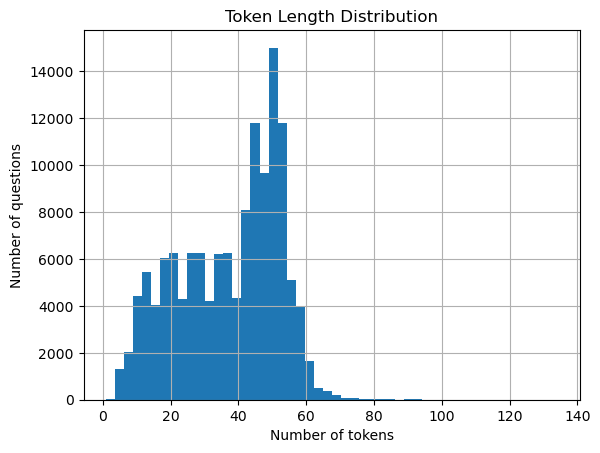

In [1]:
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("CleanedData.csv").dropna()

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")

# Calculate token lengths
token_lengths = df["Question"].apply(lambda x: len(tokenizer.tokenize(str(x))))

# Show statistics
print("Max token length:", token_lengths.max())
print("95th percentile:", token_lengths.quantile(0.95))
print("Average token length:", token_lengths.mean())

# Optional: Plot distribution
token_lengths.hist(bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Number of questions")
plt.grid(True)
plt.show()

In [3]:
import pandas as pd
import numpy as np
import torch
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate
import pickle
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from farasa.segmenter import FarasaSegmenter
from tqdm import tqdm

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


True
NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
import torch
print(torch.__version__)


2.7.0+cu118


In [5]:


# 1. Load Data
df = pd.read_csv("CleanedData.csv").dropna()

# 2. Arabic Cleaning & Preprocessing
farasa = FarasaSegmenter(interactive=True)

def normalize_arabic(text):
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", text)  # Keep Arabic chars only
    text = re.sub(r"[إأآا]", "ا", text)
    text = re.sub(r"ى", "ي", text)
    text = re.sub(r"ؤ", "و", text)
    text = re.sub(r"ئ", "ي", text)
    text = re.sub(r"ة", "ه", text)
    text = re.sub(r"[ًٌٍَُِّْ]", "", text)  # Remove diacritics
    text = re.sub(r"(.)\1{2,}", r"\1", text)  # Remove elongations (e.g., كوووول => كول)
    return text

def preprocess_text(text):
    text = normalize_arabic(text)
    text = farasa.segment(text)  # AraBERT-specific
    return text

print("Preprocessing Arabic Text...")
df["Question"] = [preprocess_text(t) for t in tqdm(df["Question"])]

# 3. Encode Labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Master_Category"])
num_labels = df["label"].nunique()

# 4. Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Question"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# 5. Load Tokenizer
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# 6. Prepare Dataset
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(tokenize, batched=True)
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels}).map(tokenize, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# 7. Load Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# 8. Metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }

# 9. Training Arguments
training_args = TrainingArguments(
    output_dir="./arabert2_classifier",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,  # Enable mixed precision if using GPU
    logging_dir='./logs',
    logging_steps=200
)

# 10. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 11. Train
trainer.train()

# 12. Evaluate
results = trainer.evaluate()
print("Evaluation Results:", results)

# 13. Save Model & Tokenizer
model.save_pretrained("arabert2_classifier")
tokenizer.save_pretrained("arabert2_classifier")

# Save Label Encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# 14. Predict on test set
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_test_enc = predictions.label_ids

# 15. Predict on train set
train_predictions = trainer.predict(train_dataset)
y_train_pred = np.argmax(train_predictions.predictions, axis=1)
y_train_enc = train_predictions.label_ids

# 16. Metrics Report
train_accuracy = accuracy_score(y_train_enc, y_train_pred)
test_accuracy = accuracy_score(y_test_enc, y_pred)
precision = precision_score(y_test_enc, y_pred, average='weighted')
recall = recall_score(y_test_enc, y_pred, average='weighted')
f1_micro = f1_score(y_test_enc, y_pred, average='micro')

print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")


[2025-05-29 02:37:20,931 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


Preprocessing Arabic Text...


Map: 100%|██████████| 27186/27186 [00:01<00:00, 14204.02 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\.conda\envs\ara\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_15048\970497598.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.495200,0.468478,0.854300,0.853303
2,0.423200,0.448868,0.858493,0.857955
3,0.352300,0.447061,0.859192,0.858125


Evaluation Results: {'eval_loss': 0.4470614492893219, 'eval_accuracy': 0.8591922312955198, 'eval_f1': 0.8581249341274142, 'eval_runtime': 38.3474, 'eval_samples_per_second': 708.94, 'eval_steps_per_second': 11.083, 'epoch': 3.0}


                                 precision    recall  f1-score   support

                        الأورام       0.82      0.88      0.85      2472
                        الجراحة       0.75      0.69      0.72      2471
                    الطب النفسي       0.91      0.89      0.90      2472
                النساء والولادة       0.87      0.86      0.86      2472
                  امراض الاطفال       0.87      0.91      0.89      2472
                 امراض الباطنية       0.78      0.73      0.75      2471
          جراحة العظام والمفاصل       0.87      0.89      0.88      2472
جراحة المسالك البولية و الانجاب       0.86      0.86      0.86      2471
                          جلدية       0.84      0.83      0.84      2470
                     طب الاسنان       0.93      0.94      0.94      2472
                      طب العيون       0.94      0.96      0.95      2471

                       accuracy                           0.86     27186
                      macro avg       0.86      0